# PyTorch 关于CIFAR的分类

## 导入必要包

导入会使用的包，其中DataLoader是自由读取数据，可能不需要？

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt 

## CIFAR10数据集

### CIFAR10简介

CIFAR-10 是一个更接近普通物体的彩色图像数据集。CIFAR-10 是由Hinton 的学生Alex Krizhevsky 和Ilya Sutskever 整理的一个用于识别普通物体的小型数据集。图片的尺寸为32 × 32，数据集中一共有50000 张训练图片和10000 张测试图片，一共包含10个类别的RGB 彩色图片：
- 0. 飞机（ airplane ）
- 1. 汽车（ automobile ）
- 2. 鸟类（ bird ）
- 3. 猫（ cat ）
- 4. 鹿（ deer ）
- 5. 狗（ dog ）
- 6. 蛙（ frog ）
- 7. 马（ horse ）
- 8. 船（ ship ）
- 9. 卡车（ truck ）

与MNIST 数据集相比，CIFAR-10具有以下不同点:

- CIFAR-10 是3 通道的彩色RGB图像，而MNIST 是灰度图像。
- CIFAR-10 的图片尺寸为32 × 32 ， 而MNIST 的图片尺寸为28 × 28 ，比MNIST 稍大。
- 相比于手写字符， CIFAR-10 含有的是现实世界中真实的物体，不仅噪声很大，而且物体的比例、特征都不尽相同，这为识别带来很大困难。直接的线性模型如Softmax 在CIFAR-10 上表现得很差。

### 数据集导入及分析

导入数据集参考代码：

In [4]:
CIFAR10_trainset = datasets.CIFAR10(root='./cifar10_data', train=True, download=True, transform=None)
CIFAR10_testset = datasets.CIFAR10(root='./cifar10_data', train=False, download=True, transform=None)
print(len(CIFAR10_trainset))
print(len(CIFAR10_testset))

50000
10000


检查数据集图片格式，发现和MNIST一样是PIL格式，分辨率为32×32，色彩为RGB。

In [5]:
CIFAR10_trainset[0]

(<PIL.Image.Image image mode=RGB size=32x32 at 0x7FCA6590D278>, 6)

通过 plt.imshow() 函数检查图片，可以看出训练集第1张图片（编号0）是青蛙，标签为数字6。这里把标签数字化了。

该图片的标签是：  6


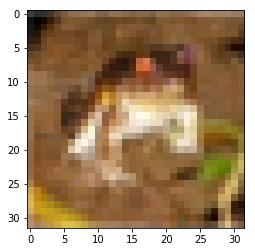

In [6]:
test_image_zero, test_target_zero = CIFAR10_trainset[0]
plt.imshow(test_image_zero, cmap=None)  # 彩色图像
print("该图片的标签是： ",test_target_zero)

### LeNet-5网络分析

参考链接：https://cuijiahua.com/blog/2018/01/dl_3.html

LeNet-5是一个早期的、经典的神经网络模型。根据上方连接中的文章我们将利用Pytorch框架手写一个LeNet-5。

In [29]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1)
        self.fc1 = nn.Linear(in_features=5*5*16, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=84)
        self.fc3 = nn.Linear(in_features=84, out_features=10)

    def forward(self, x):
        x = F.max_pool2d(self.conv1(x), kernel_size=2, stride=2)
        x = F.max_pool2d(self.conv2(x), kernel_size=2, stride=2)
        x = x.view(-1, 5*5*16)
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [30]:
data_tf = transforms.Compose([transforms.ColorJitter(brightness=0.1, contrast=0.1),  # 色调变化
                              transforms.RandomAffine(degrees=5, scale=(0.9, 1.1)),  # 随机放射变换
                              transforms.ToTensor(),  # 变化为tensor
                              transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])  # 标准化处理

mnist_trainset = datasets.CIFAR10(root='./cifar10_data', train=True, download=True, transform=data_tf)
mnist_testset = datasets.CIFAR10(root='./cifar10_data', train=False, download=True, transform=data_tf)

train_loader = DataLoader(mnist_trainset, batch_size=1000, shuffle=True)
test_loader = DataLoader(mnist_testset, batch_size=1000, shuffle=True)  # 测试集无需打乱

Files already downloaded and verified
Files already downloaded and verified


In [35]:
net = Net()
if torch.cuda.is_available():  # 如果GPU可以使用
    net = net.cuda()
    print("CUDA is available.")
optimizer = torch.optim.SGD(net.parameters(), lr=0.005)
loss_func = torch.nn.CrossEntropyLoss()

CUDA is available.


In [36]:
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


In [37]:
net.train()  # 启用train模式
for epoch in range(10):
    for batch_ndx, (img, label) in enumerate(train_loader):  # 按照一个batch = 1000来抽取数据   
        # 前向传播
        if torch.cuda.is_available():
            img = img.cuda()
            label = label.cuda()
            # print("使用CUDA训练")
        else:
            pass
        output = net(img)
        loss = loss_func(output, label)
        
        # 反向传播
        optimizer.zero_grad()  # 梯度归零
        loss.backward()  # 损失函数反向传播
        optimizer.step()
        
        if batch_ndx%10 == 0:
            print('epoch: {}, batch_ndx: {}, loss: {:.4}'.format(epoch, batch_ndx, loss.data.item()))  

epoch: 0, batch_ndx: 0, loss: 2.304
epoch: 0, batch_ndx: 10, loss: 2.304
epoch: 0, batch_ndx: 20, loss: 2.305
epoch: 0, batch_ndx: 30, loss: 2.302
epoch: 0, batch_ndx: 40, loss: 2.299
epoch: 1, batch_ndx: 0, loss: 2.298
epoch: 1, batch_ndx: 10, loss: 2.299
epoch: 1, batch_ndx: 20, loss: 2.298
epoch: 1, batch_ndx: 30, loss: 2.302
epoch: 1, batch_ndx: 40, loss: 2.294
epoch: 2, batch_ndx: 0, loss: 2.297
epoch: 2, batch_ndx: 10, loss: 2.297
epoch: 2, batch_ndx: 20, loss: 2.294
epoch: 2, batch_ndx: 30, loss: 2.295
epoch: 2, batch_ndx: 40, loss: 2.295
epoch: 3, batch_ndx: 0, loss: 2.293
epoch: 3, batch_ndx: 10, loss: 2.293
epoch: 3, batch_ndx: 20, loss: 2.291
epoch: 3, batch_ndx: 30, loss: 2.294
epoch: 3, batch_ndx: 40, loss: 2.286
epoch: 4, batch_ndx: 0, loss: 2.291
epoch: 4, batch_ndx: 10, loss: 2.286
epoch: 4, batch_ndx: 20, loss: 2.284
epoch: 4, batch_ndx: 30, loss: 2.29
epoch: 4, batch_ndx: 40, loss: 2.279
epoch: 5, batch_ndx: 0, loss: 2.28
epoch: 5, batch_ndx: 10, loss: 2.28
epoch: 5, 

In [38]:
net.eval()
eval_loss = 0
eval_acc = 0

# 对测试集进行测试
for batch_ndx, data in enumerate(test_loader):
    # 获得img(手写图片)，label标签（手写图片对应数字）
    img, label = data
    if torch.cuda.is_available():
        img = img.cuda()
        label = label.cuda()
        # print("使用CUDA训练")
    else:
        pass    
    #  向前传播，获得out结果和损失函数
    output = net(img)
    loss = loss_func(output, label)  # 交叉熵
    
    # 损失函数乘标签大小累计
    eval_loss += loss.data.item()*label.size(0)  # 每个计算一次损失？
    # 在10维数据中，获得最大的预测值（即预测数）
    _, pred = torch.max(output, 1)
    # 判断是否与真实结果相同
    num_correct = (pred == label).sum()
    
    # 累计真实结果
    eval_acc += num_correct.item()

print(label.size(0))
# 输出评估结果    
print('Test Loss: {:.6f}, Acc: {:.6f}'.format(
    eval_loss / (len(mnist_testset)),
    eval_acc / (len(mnist_testset))
))

1000
Test Loss: 2.145710, Acc: 0.222700
